In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from chexnet import ChexNet
from unet import Unet
from dataset import ChestXray14Dataset
from transform import tta
from metrics import aucs
from constant import CLASS_NAMES, IMAGENET_MEAN, IMAGENET_STD, SCALE_FACTOR
from fastai.conv_learner import *

import pandas as pd
import skimage
from scipy import ndimage
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torchvision.transforms as transforms

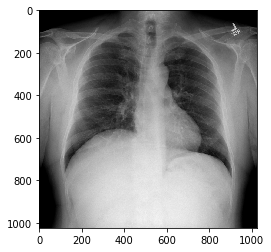

In [44]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
image_name = '00022835_006.png'
image = Image.open(PATH/IMAGE_DN/image_name).convert('RGB')
plt.imshow(image)

In [5]:
unet_model = '20190211-101020'
unet = Unet(trained=True, model_name=unet_model).cuda()
unet.eval();

# Global Image

### No Crop

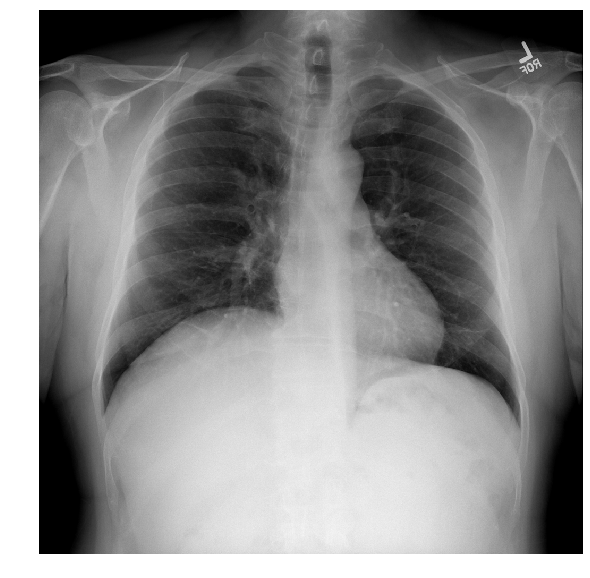

In [45]:
tfm = transforms.Resize(224)
img= tfm(image)
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)
ax.set_axis_off()

In [7]:
### Five Crop

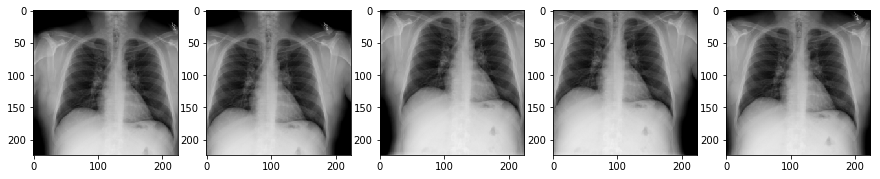

In [7]:
tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.FiveCrop(224)
])
imgs = tfm(image)
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = imgs[i]
    ax.imshow(img)


# Segmentation

In [50]:
from heatmap import HeatmapGenerator
image_file = PATH/IMAGE_DN/image_name
chexnet = ChexNet(model_name='20180429-130928')
g = HeatmapGenerator(chexnet, mode='cam')

In [46]:
from skimage import morphology, color

def plot_lung_segment(image, mask, gt_mask=None, ax=None, boundary=False):
    if not ax: fig, ax = plt.subplots(figsize=(12, 10))
    image = blend_segmentation(image, mask, gt_mask, boundary, alpha=1)
    ax.imshow(image)
#     ax.imshow(image)
#     if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
#     ax.imshow(mask, alpha=0.4, vmin=0, vmax=1, cmap='Reds')
#     if gt_mask is not None:
#         boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
#         ax.imshow(boundary, alpha=0.4, vmin=0, vmax=1, cmap='Greens')
    ax.set_axis_off()

def blend_segmentation(image, mask, gt_mask=None, boundary=False, alpha=1):
    h, w = image.size
    color_mask = np.zeros((h, w, 3)) # PIL Image
    if boundary: mask = morphology.dilation(mask, morphology.disk(3)) - mask
    color_mask[mask==1] = [1, 0, 0] # RGB
    
    if gt_mask is not None:
        gt_boundary = morphology.dilation(gt_mask, morphology.disk(3)) - gt_mask
        color_mask[gt_boundary==1] = [0, 1, 0] # RGB
    
    image_hsv = color.rgb2hsv(image)
    color_mask_hsv = color.rgb2hsv(color_mask)
    
    image_hsv[..., 0] = color_mask_hsv[..., 0]
    image_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    
    return color.hsv2rgb(image_hsv)

In [47]:
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
toTensor = transforms.ToTensor()
tfm = transforms.Compose([
    transforms.Resize(256),
    toTensor,
    normalize
])

In [58]:
py = unet(V(tfm(image)[None]))
py = (py[0].cpu() > 0.5).type(torch.FloatTensor)


labels = skimage.measure.label(py[0].numpy())
idx = np.argsort(-np.bincount(labels.flat)) # get index of each label
mask = np.logical_or(labels==idx[1], labels==idx[2]).astype(np.float32) # left nd right lung, 0 for background
mask = cv2.resize(mask, (1024, 1024))
slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
h, w = slice_y.stop - slice_y.start, slice_x.stop - slice_x.start
ratio = w*1./h

nw, nh = int(w/0.875), int(h/0.875)
dw, dh = (nw-w)//2, (nh-h)//2
t = max(slice_y.start-dh, 0)
l = max(slice_x.start-dw, 0)
b = min(slice_y.stop+dh, 1024)
r = min(slice_x.stop+dw, 1024)
w, h = r-l, b-t

xy = (slice_x.start, slice_y.start)
xy = (l, t)
height = b-t
width= r-l

/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


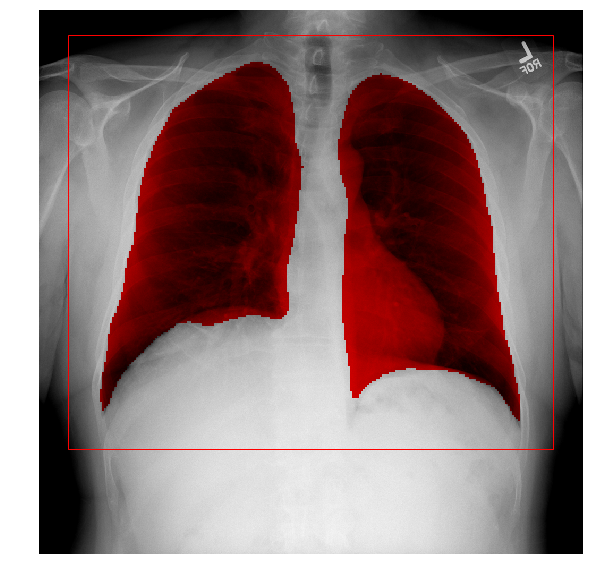

In [59]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(12, 10))
plot_lung_segment(image, mask, ax=ax)
rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

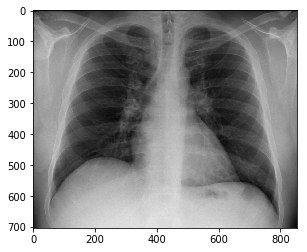

In [15]:
plt.imshow(segmented)

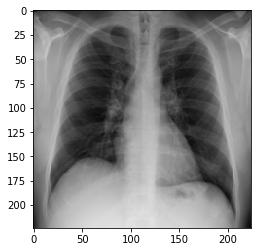

In [17]:
tfm = transforms.Resize((224, 224))
img= tfm(segmented)
plt.imshow(img)

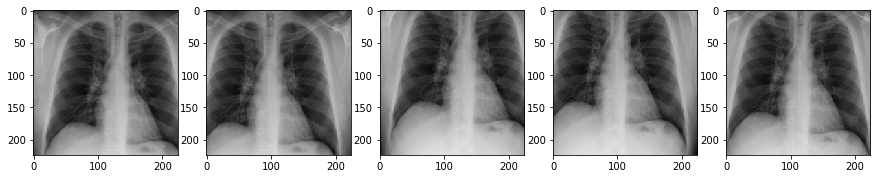

In [18]:
tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.FiveCrop(224)
])
imgs = tfm(segmented)
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = imgs[i]
    ax.imshow(img)